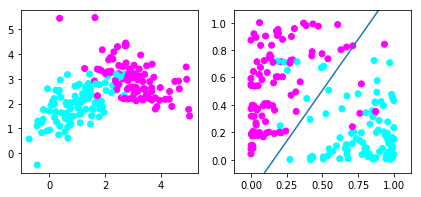

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from sklearn.metrics import f1_score

mean_1 = np.array([1,2])
mean_2 = np.array([3,3])
cov_1 = np.array([[0.5, 0.3],[0.3, 0.5]])
cov_2 = np.array([[0.7, -0.3],[-0.3, 0.5]])

sigmoid = lambda a: 1/(1+np.exp(-a))
y = lambda w,Phi: sigmoid(np.matmul(Phi, w.reshape(-1,1)))
rbf = lambda x,mu=0,s=1: np.exp(-(x-mu)**2/(2*s**2))

def generate_dataset(N):
    Nh = int(N/2)
    order = np.random.permutation(N)
    X1 = st.multivariate_normal.rvs(mean_1, cov_1, Nh)
    X2 = st.multivariate_normal.rvs(mean_2, cov_2, Nh)
    X = np.concatenate((X1, X2))[order]
    T1 = np.zeros((Nh,1))
    T2 = np.ones((Nh,1))
    T = np.concatenate((T1,T2))[order]
    return X, T

def loss(Y, T):
    Y_temp = np.copy(Y)
    Y_temp[Y_temp == 1] = 1 - np.finfo(Y_temp.dtype).eps
    return - np.mean(T * np.log(Y) + (1 - T) * np.log(1 - Y_temp))

def calc_phi(X):
    I = np.ones((len(X),1))
    b1 = rbf(X[:,0],0.9,1).reshape(-1,1)
    b2 = rbf(X[:,1],4,1).reshape(-1,1)
      
    return np.concatenate((I, b1, b2), axis=1)

def calc_gradient(w, Phi, T):
    Y = y(w, Phi)
    m = 1
    if(type(T)!=np.float64):
        m=len(T)
    return 1/m * np.matmul((Y - T).T, Phi)
    
def fit_gradient_descent(Phi, T, a = 1, steps = 1000):
    w = np.zeros(Phi.shape[1])
    for epoch in range(steps):
        G = calc_gradient(w,Phi,T)
        w = w - a * G[0]
    return w

def fit_SGD(Phi, T, a = 1, steps = 1000):
    w = np.zeros(Phi.shape[1])
    Phi_c = np.concatenate((Phi, T),axis=1)
    for epoch in range(steps):
        np.random.shuffle(Phi_c)
        for elem in Phi_c:
            G = calc_gradient(w,elem[:3].reshape(1,-1),elem[3])
            w = w - a * G[0]
    return w

def fit_minibatch(Phi, T, a = 1, steps = 10000):
    w = np.zeros(Phi.shape[1])
    Phi_c = np.concatenate((Phi, T),axis=1)
    for epoch in range(steps):
        np.random.shuffle(Phi_c)
        batch = Phi_c[:32]
        G = calc_gradient(w,batch[:,:3],batch[:,3])
        w = w - a * G[0]
    return w

N = 200
alpha = 0.01

X, T = generate_dataset(N)
Phi = calc_phi(X)
#w = fit_gradient_descent(Phi, T, a = alpha, steps = 100)
w = fit_SGD(Phi, T, a = alpha, steps = 5)
#w = fit_minibatch(Phi, T, a = alpha, steps = 10000)

x_scatter = Phi[:,1]
y_scatter = Phi[:,2]
x_offset = np.mean(x_scatter)/4
y_offset = np.mean(y_scatter)/4
x_min = np.min(x_scatter) - x_offset
x_max = np.max(x_scatter) + x_offset

plt.figure(figsize=(7,3))

plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], c = T.reshape(len(T),), cmap='cool')

plt.subplot(1,2,2)
plt.xlim(x_min, x_max)
plt.ylim(np.min(y_scatter) - y_offset, np.max(y_scatter) + y_offset)
plt.scatter(x_scatter, y_scatter, c = T.reshape(len(T),), cmap='cool')

X_plot = np.linspace(x_min, x_max, 2)
Y_plot = -(w[0] + w[1] * X_plot) / (w[2])
plt.plot(X_plot, Y_plot)

X_test, T_test = generate_dataset(200)
Y_test = y(w, calc_phi(X_test))
print("w*:", w)
print("F1 Score:", f1_score(T_test,np.around(Y_test)))

plt.show()